# Credit Card Approval Prediction : A Business and Data Analysis Report

## Introduction

In the financial services industry, understanding and predicting customer behavior is crucial for risk management and decision-making. This project focuses on analyzing the creditworthiness of clients using historical application and credit record data. The objective is to develop predictive models that can classify clients as 'good' or 'bad' credit risks. 'Good' credit risks are clients who are likely to meet their credit obligations on time, while 'bad' credit risks are clients who are likely to default or have overdue payments.This classification helps financial institutions in minimizing defaults while optimizing credit allocation.

## Data Exploration

Before diving into model building, it's essential to understand the data at hand. The datasets used in this project include `application_record.csv`, which contains demographic and financial details of clients, and `credit_record.csv`, which tracks their credit history over time.

In [2]:
# Import necessary libraries
import pandas as pd

# Load datasets
application_df = pd.read_csv("../data/raw/application_record.csv")
credit_df = pd.read_csv("../data/raw/credit_record.csv")

# Display first few rows of application data
print(application_df.head())

# Display first few rows of credit data
print(credit_df.head())

# Basic information about datasets
print(application_df.info())
print(credit_df.info())

# Check if 'TARGET' column is in the dataset (you may need to add or rename it)
print("Columns in application_df:", application_df.columns)
print("Columns in credit_df:", credit_df.columns)

        ID CODE_GENDER FLAG_OWN_CAR FLAG_OWN_REALTY  CNT_CHILDREN  \
0  5008804           M            Y               Y             0   
1  5008805           M            Y               Y             0   
2  5008806           M            Y               Y             0   
3  5008808           F            N               Y             0   
4  5008809           F            N               Y             0   

   AMT_INCOME_TOTAL      NAME_INCOME_TYPE            NAME_EDUCATION_TYPE  \
0          427500.0               Working               Higher education   
1          427500.0               Working               Higher education   
2          112500.0               Working  Secondary / secondary special   
3          270000.0  Commercial associate  Secondary / secondary special   
4          270000.0  Commercial associate  Secondary / secondary special   

     NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  DAYS_BIRTH  DAYS_EMPLOYED  \
0        Civil marriage   Rented apartment      -12005 

The application_df dataset includes key attributes such as gender, income, employment status, and the number of dependents, which are pivotal in determining the client's ability to repay loans. On the other hand, the credit_df dataset captures the client's payment history, which directly reflects their credit behavior. By merging these datasets, we can create a comprehensive view of each client that includes both their capacity to repay (from the application data) and their willingness to repay (from the credit data). The OCCUPATION_TYPE column has a significant number of missing values, which must be handled during preprocessing. These missing values could be filled based on other correlated variables or imputed using statistical techniques.


Understanding client profiles through this data is critical for financial institutions. For instance, clients with high income but poor credit history might be considered higher risk compared to those with moderate income and a spotless payment history. Thus, the merging of these datasets allows for more nuanced decision-making, enabling the institution to balance between potential revenue (from interest payments) and risk (from defaults).

## Data Preprocessing
To prepare the data for modeling, it must be cleaned and transformed. This involves handling missing values, encoding categorical variables, and creating new features that might enhance model performance. The OCCUPATION_TYPE column contains many missing values, which need to be addressed during preprocessing to maintain data quality and model accuracy. STATUS values of 2, 3, 4, and 5 indicate clients with increasingly severe overdue payments, making them higher risk for default.

In [3]:
# Import necessary libraries
import pandas as pd


# Function to load data
def load_data():
    application_df = pd.read_csv("../data/raw/application_record.csv")
    credit_df = pd.read_csv("../data/raw/credit_record.csv")
    return application_df, credit_df


# Function to preprocess data
def preprocess_data(application_df, credit_df):
    # Handle missing values
    application_df.fillna(application_df.median(numeric_only=True), inplace=True)

    # Convert categorical columns to numeric using one-hot encoding
    categorical_cols = [
        "CODE_GENDER",
        "FLAG_OWN_CAR",
        "FLAG_OWN_REALTY",
        "NAME_INCOME_TYPE",
        "NAME_EDUCATION_TYPE",
        "NAME_FAMILY_STATUS",
        "NAME_HOUSING_TYPE",
        "OCCUPATION_TYPE",
    ]

    application_df = pd.get_dummies(
        application_df, columns=categorical_cols, drop_first=True
    )

    # Create 'TARGET' column: 1 if STATUS indicates overdue payments, else 0
    credit_df["TARGET"] = credit_df["STATUS"].apply(
        lambda x: 1 if x in ["2", "3", "4", "5"] else 0
    )

    # Aggregate 'TARGET' to have one row per ID
    credit_agg = credit_df.groupby("ID")["TARGET"].max().reset_index()

    # Merge datasets on ID column
    merged_data = pd.merge(application_df, credit_agg, on="ID", how="inner")

    return merged_data


# Load and preprocess data
application_df, credit_df = load_data()
merged_data = preprocess_data(application_df, credit_df)

# Save preprocessed data
merged_data.to_csv("../data/processed/merged_data.csv", index=False)

# Display first few rows of merged data
print(merged_data.head())

# Check the columns to ensure 'TARGET' is present
print("Columns in merged_data:", merged_data.columns)

        ID  CNT_CHILDREN  AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  \
0  5008804             0          427500.0      -12005          -4542   
1  5008805             0          427500.0      -12005          -4542   
2  5008806             0          112500.0      -21474          -1134   
3  5008808             0          270000.0      -19110          -3051   
4  5008809             0          270000.0      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  ...  \
0           1                1           0           0              2.0  ...   
1           1                1           0           0              2.0  ...   
2           1                0           0           0              2.0  ...   
3           1                0           1           1              1.0  ...   
4           1                0           1           1              1.0  ...   

   OCCUPATION_TYPE_Low-skill Laborers  OCCUPATION_TYPE_Managers  \
0            

Data preprocessing is a critical step to ensure that the data fed into the machine learning models is clean and well-structured. For example, categorical variables like CODE_GENDER and FLAG_OWN_CAR are converted into numerical values through one-hot encoding. Additionally, the TARGET variable is created to indicate whether a client has had overdue payments, which will serve as the dependent variable in our predictive models. STATUS values 2, 3, 4, and 5 represent clients who have overdue payments of varying severity. These were selected to identify clients at higher risk of default, as each of these values corresponds to increasingly severe levels of delinquency.

Proper data preprocessing not only improves the accuracy of predictive models but also ensures that business decisions based on these models are reliable. For instance, by carefully handling missing values and encoding variables correctly, we reduce the risk of making erroneous predictions that could lead to either rejecting a creditworthy client or approving a high-risk loan.

## Feature Engineering
Feature engineering involves creating new features that might enhance the predictive power of the model. For example, calculating the Income_Per_Family_Member provides insights into the financial burden on the client, which could be a significant predictor of their creditworthiness. Lenders often assess a client’s disposable income after accounting for dependents. By calculating Income_Per_Family_Member, we account for the financial strain that dependents place on a client's income, which provides a more accurate measure of their financial stability and repayment capacity.

In [4]:
# Import necessary libraries
import pandas as pd

# Load preprocessed data
merged_data = pd.read_csv("../data/processed/merged_data.csv")


# Function for feature engineering
def feature_engineering(merged_data):
    # Feature engineering example
    merged_data["Income_Per_Family_Member"] = (
        merged_data["AMT_INCOME_TOTAL"] / merged_data["CNT_FAM_MEMBERS"]
    )

    # Encode categorical variables (already done in preprocessing)

    return merged_data


# Apply feature engineering
feature_engineered_data = feature_engineering(merged_data)

# Save feature-engineered data
feature_engineered_data.to_csv(
    "../data/processed/feature_engineered_data.csv", index=False
)

# Display first few rows of feature engineered data
print(feature_engineered_data.head())

# Check the columns to ensure 'TARGET' is present
print("Columns in feature_engineered_data:", feature_engineered_data.columns)

        ID  CNT_CHILDREN  AMT_INCOME_TOTAL  DAYS_BIRTH  DAYS_EMPLOYED  \
0  5008804             0          427500.0      -12005          -4542   
1  5008805             0          427500.0      -12005          -4542   
2  5008806             0          112500.0      -21474          -1134   
3  5008808             0          270000.0      -19110          -3051   
4  5008809             0          270000.0      -19110          -3051   

   FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  ...  \
0           1                1           0           0              2.0  ...   
1           1                1           0           0              2.0  ...   
2           1                0           0           0              2.0  ...   
3           1                0           1           1              1.0  ...   
4           1                0           1           1              1.0  ...   

   OCCUPATION_TYPE_Managers  OCCUPATION_TYPE_Medicine staff  \
0                

Feature engineering plays a crucial role in improving the performance of predictive models. By creating the Income_Per_Family_Member feature, we gain a more granular view of the client's financial stability, which is likely to be a strong predictor of their ability to manage debt. This feature helps differentiate between clients with similar total incomes but different family sizes, providing the model with more nuanced information.

From a business perspective, the Income_Per_Family_Member feature allows lenders to better assess the financial strain on clients. A lower value might indicate higher financial burden, suggesting that the client is at greater risk of default. Thus, this feature aids in identifying clients who, despite having a high total income, may still struggle to meet their financial obligations due to the number of dependents.

/tmp/ipykernel_2859636/897841493.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=y, palette="viridis")


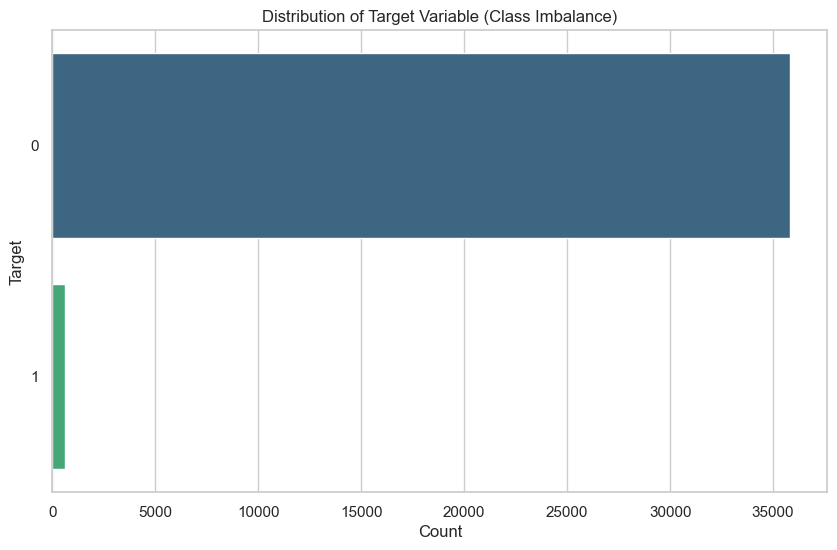

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

X = feature_engineered_data.drop("TARGET", axis=1)
y = feature_engineered_data["TARGET"]

# Set a style for the plots
sns.set(style="whitegrid")

# Visualization 1: Distribution of Target Variable
plt.figure(figsize=(10, 6))
sns.countplot(y=y, palette="viridis")
plt.title("Distribution of Target Variable (Class Imbalance)")
plt.xlabel("Count")
plt.ylabel("Target")
plt.show()

The Distribution of the Target Variable, which highlights the class imbalance in your dataset.

-- The Target variable represents the classification of clients as either 'good'    (likely to meet their credit obligations) or 'bad' (likely to default).

The majority of the clients are classified as '0' (good), which is represented by the large bar.
A much smaller portion of clients are classified as '1' (bad), shown by the smaller bar.

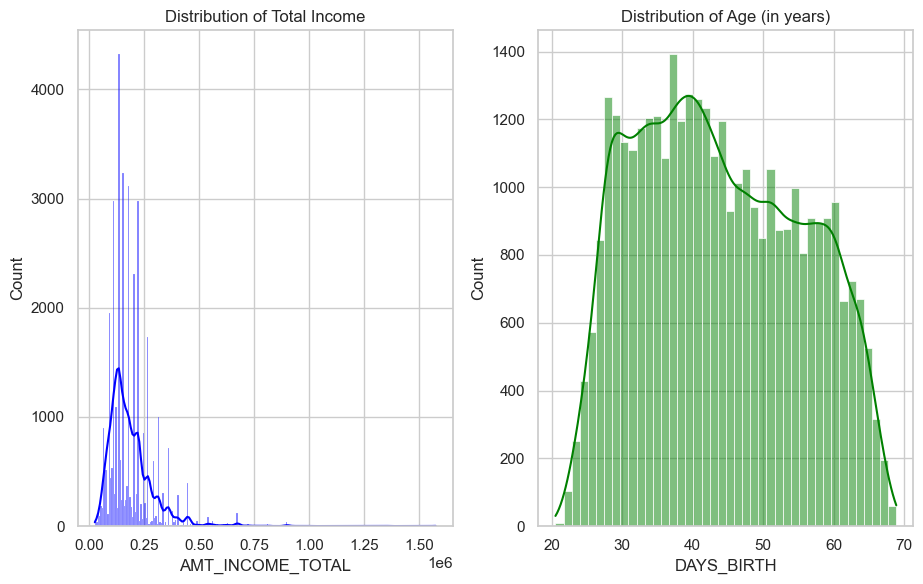

In [6]:
# Plot histograms for key numerical features
plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
sns.histplot(merged_data["AMT_INCOME_TOTAL"], kde=True, color="blue")
plt.title("Distribution of Total Income")

plt.subplot(1, 3, 2)
sns.histplot(abs(merged_data["DAYS_BIRTH"]) / 365, kde=True, color="green")
plt.title("Distribution of Age (in years)")


plt.tight_layout()
plt.show()

Graph on left displays the distribution of clients' income levels in the dataset.

Understanding the income distribution helps in assessing the financial capacity of the clients. It gives insights into whether the dataset contains more low-income or high-income clients, which could influence creditworthiness.

Graph on right shows the distribution of clients' ages, derived from the DAYS_BIRTH feature (converted to years).

Age can be a critical factor in credit risk assessment. Younger clients might have different spending and repayment behaviors compared to older clients.

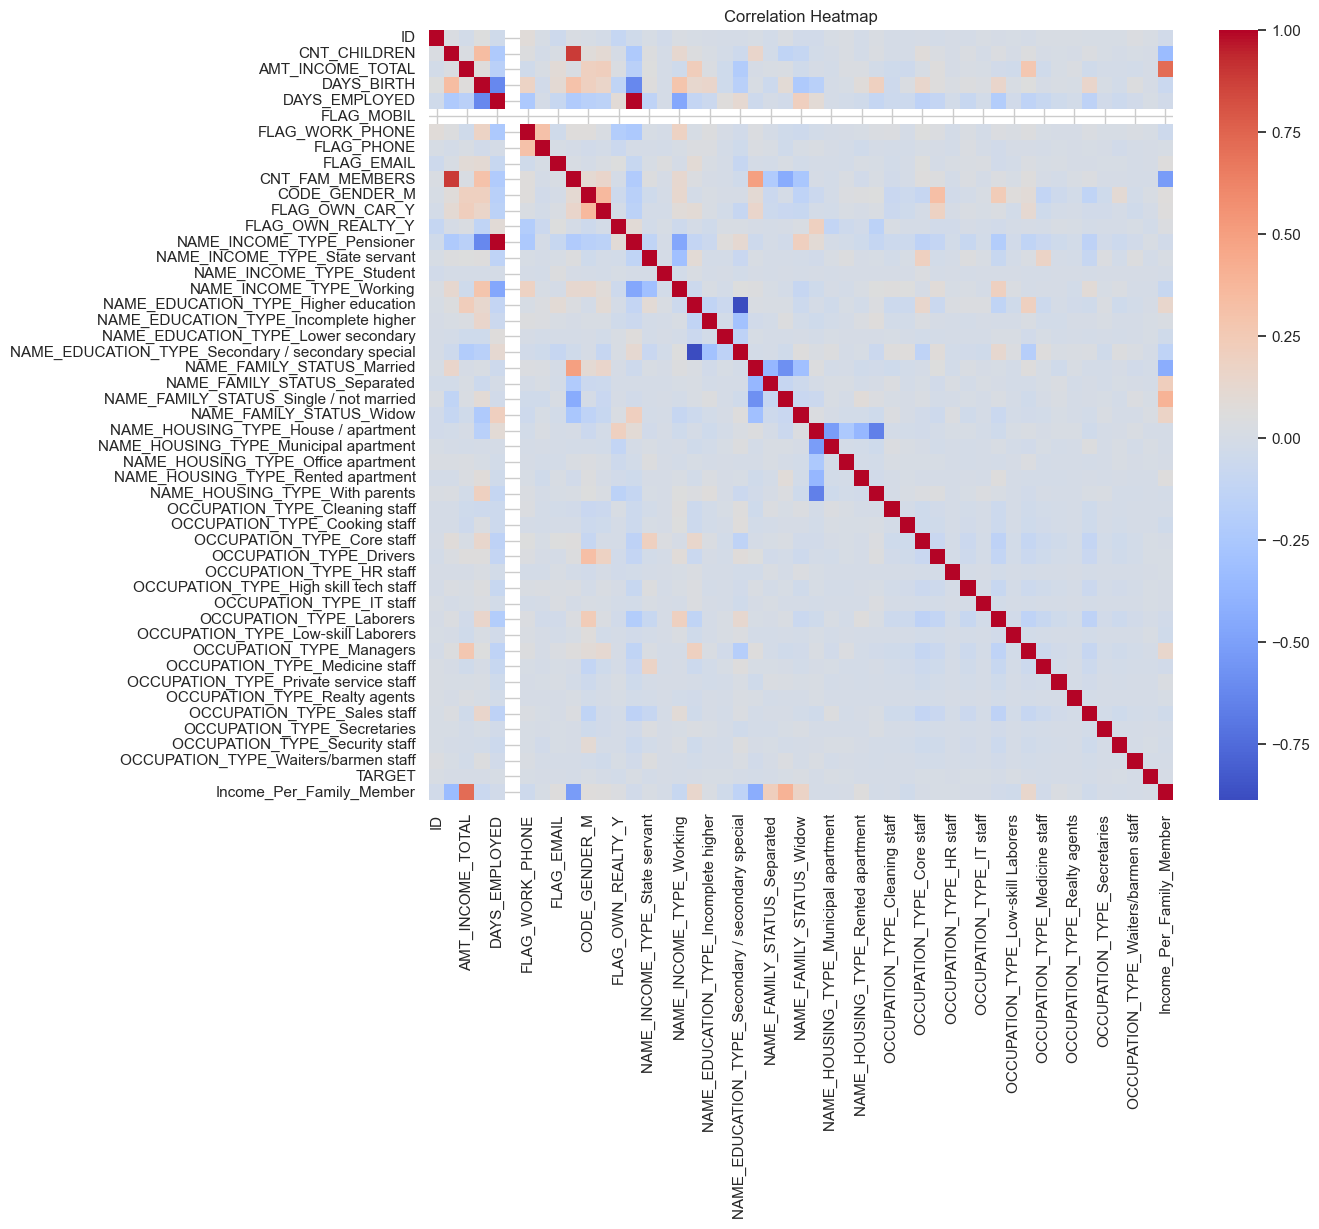

In [7]:
# Correlation heatmap
plt.figure(figsize=(12, 10))
corr_matrix = feature_engineered_data.corr()
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Correlation heatmap visualizes the correlation between different features in the dataset. The color intensity indicates the strength of the correlation, with redder tones showing stronger positive correlations and bluer tones indicating negative correlations.

In [8]:
feature_engineered_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36457 entries, 0 to 36456
Data columns (total 49 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   ID                                                 36457 non-null  int64  
 1   CNT_CHILDREN                                       36457 non-null  int64  
 2   AMT_INCOME_TOTAL                                   36457 non-null  float64
 3   DAYS_BIRTH                                         36457 non-null  int64  
 4   DAYS_EMPLOYED                                      36457 non-null  int64  
 5   FLAG_MOBIL                                         36457 non-null  int64  
 6   FLAG_WORK_PHONE                                    36457 non-null  int64  
 7   FLAG_PHONE                                         36457 non-null  int64  
 8   FLAG_EMAIL                                         36457 non-null  int64  
 9   CNT_FA

       AMT_INCOME_TOTAL
0              427500.0
1              427500.0
2              112500.0
3              270000.0
4              270000.0
...                 ...
36452          315000.0
36453          157500.0
36454          157500.0
36455          283500.0
36456          112500.0

[36457 rows x 1 columns]


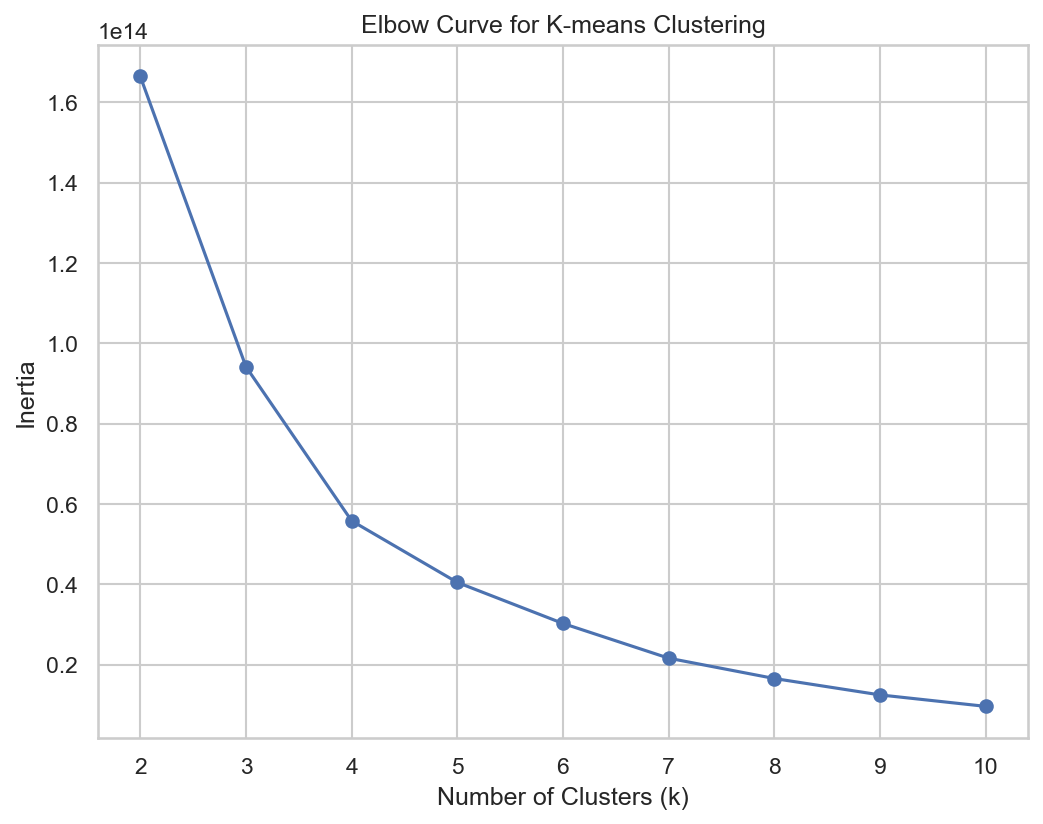

In [9]:
from sklearn.cluster import KMeans

cluster_columns = feature_engineered_data[["AMT_INCOME_TOTAL"]]


print(cluster_columns)

# Calculate inertia (sum of squared distances) for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
    kmeans.fit(cluster_columns)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6), dpi=150)
plt.plot(range(2, 11), inertia, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Curve for K-means Clustering")
plt.grid(True)
plt.show()

In [10]:
import numpy as np

numeric_columns = feature_engineered_data.select_dtypes(include=[np.number]).columns

categorical_columns = feature_engineered_data.select_dtypes(include=["object"]).columns

In [11]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

numeric_transformers = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

categorical_transformers = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformers, numeric_columns),
        ("cat", categorical_transformers, categorical_columns),
    ]
)

# Create a pipeline that includes preprocessing and clustering
kmeans_pipeline = Pipeline(
    [("preprocessor", preprocessor), ("kmeans", KMeans(n_clusters=4, random_state=42))]
)

In [12]:
# Fit the pipeline to the data
kmeans_pipeline.fit(feature_engineered_data)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['ID', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'CNT_FAM_MEMBERS', 'TARGET', 'Income_Per_Family_Member'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index([], dtype='object'))])),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [13]:
# Get cluster labels
cluster_labels = kmeans_pipeline.named_steps["kmeans"].labels_

# Add cluster labels to the dataframe
feature_engineered_data["Cluster"] = cluster_labels

feature_engineered_data.head(5)

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff,TARGET,Income_Per_Family_Member,Cluster
0,5008804,0,427500.0,-12005,-4542,1,1,0,0,2.0,...,False,False,False,False,False,False,False,0,213750.0,2
1,5008805,0,427500.0,-12005,-4542,1,1,0,0,2.0,...,False,False,False,False,False,False,False,0,213750.0,2
2,5008806,0,112500.0,-21474,-1134,1,0,0,0,2.0,...,False,False,False,False,False,True,False,0,56250.0,2
3,5008808,0,270000.0,-19110,-3051,1,0,1,1,1.0,...,False,False,False,True,False,False,False,0,270000.0,3
4,5008809,0,270000.0,-19110,-3051,1,0,1,1,1.0,...,False,False,False,True,False,False,False,0,270000.0,3


In [14]:
# Perform PCA on the preprocessed data for visualization
pca = PCA(n_components=2)
preprocessed_data = kmeans_pipeline.named_steps["preprocessor"].transform(
    feature_engineered_data
)
pca_features = pca.fit_transform(preprocessed_data)


# Create a dataframe with PCA features
pca_df = pd.DataFrame(data=pca_features, columns=["PC1", "PC2"])
pca_df["Cluster"] = cluster_labels

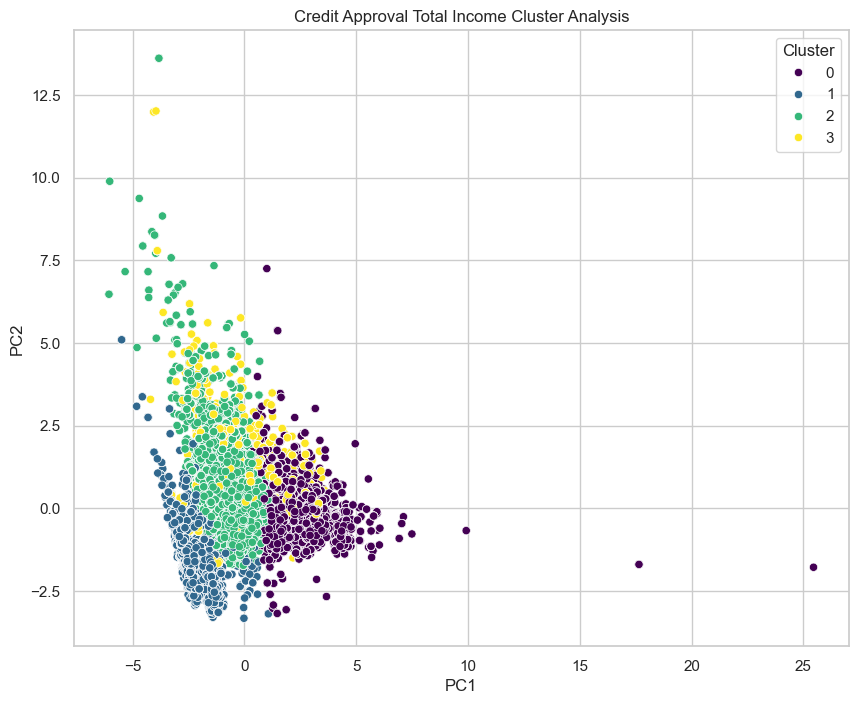

In [15]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x="PC1", y="PC2", hue="Cluster", data=pca_df, palette="viridis")
plt.title("Credit Approval Total Income Cluster Analysis")
plt.show()

In [16]:
# Analyze cluster characteristics
print("Numeric feature means for each cluster:")
print(feature_engineered_data.groupby("Cluster")[numeric_columns].mean())

Numeric feature means for each cluster:
                   ID  CNT_CHILDREN  AMT_INCOME_TOTAL    DAYS_BIRTH  \
Cluster                                                               
0        5.080982e+06      1.463360     184067.962125 -13359.085176   
1        5.074717e+06      0.026544     147375.673047 -21877.151438   
2        5.079060e+06      0.058066     195292.281888 -15620.829482   
3        5.072172e+06      0.444828     216564.070063 -14462.307524   

         DAYS_EMPLOYED  FLAG_MOBIL  FLAG_WORK_PHONE  FLAG_PHONE  FLAG_EMAIL  \
Cluster                                                                       
0           820.305690         1.0         0.276400    0.278869    0.004152   
1        365243.000000         1.0         0.000000    0.291986    0.007487   
2         -2614.429731         1.0         0.279994    0.300233    0.000000   
3         17247.032602         1.0         0.183386    0.313166    1.000000   

         CNT_FAM_MEMBERS    TARGET  Income_Per_Family_Memb

In [17]:
cluster_summary = (
    feature_engineered_data.groupby("Cluster")
    .agg({"AMT_INCOME_TOTAL": "mean", "DAYS_BIRTH": "mean", "DAYS_EMPLOYED": "mean"})
    .reset_index()
)

In [18]:
cluster_summary

,Cluster,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED
0,0,184067.962125,-13359.085176,820.305690
1,1,147375.673047,-21877.151438,365243.000000
2,2,195292.281888,-15620.829482,-2614.429731
3,3,216564.070063,-14462.307524,17247.032602


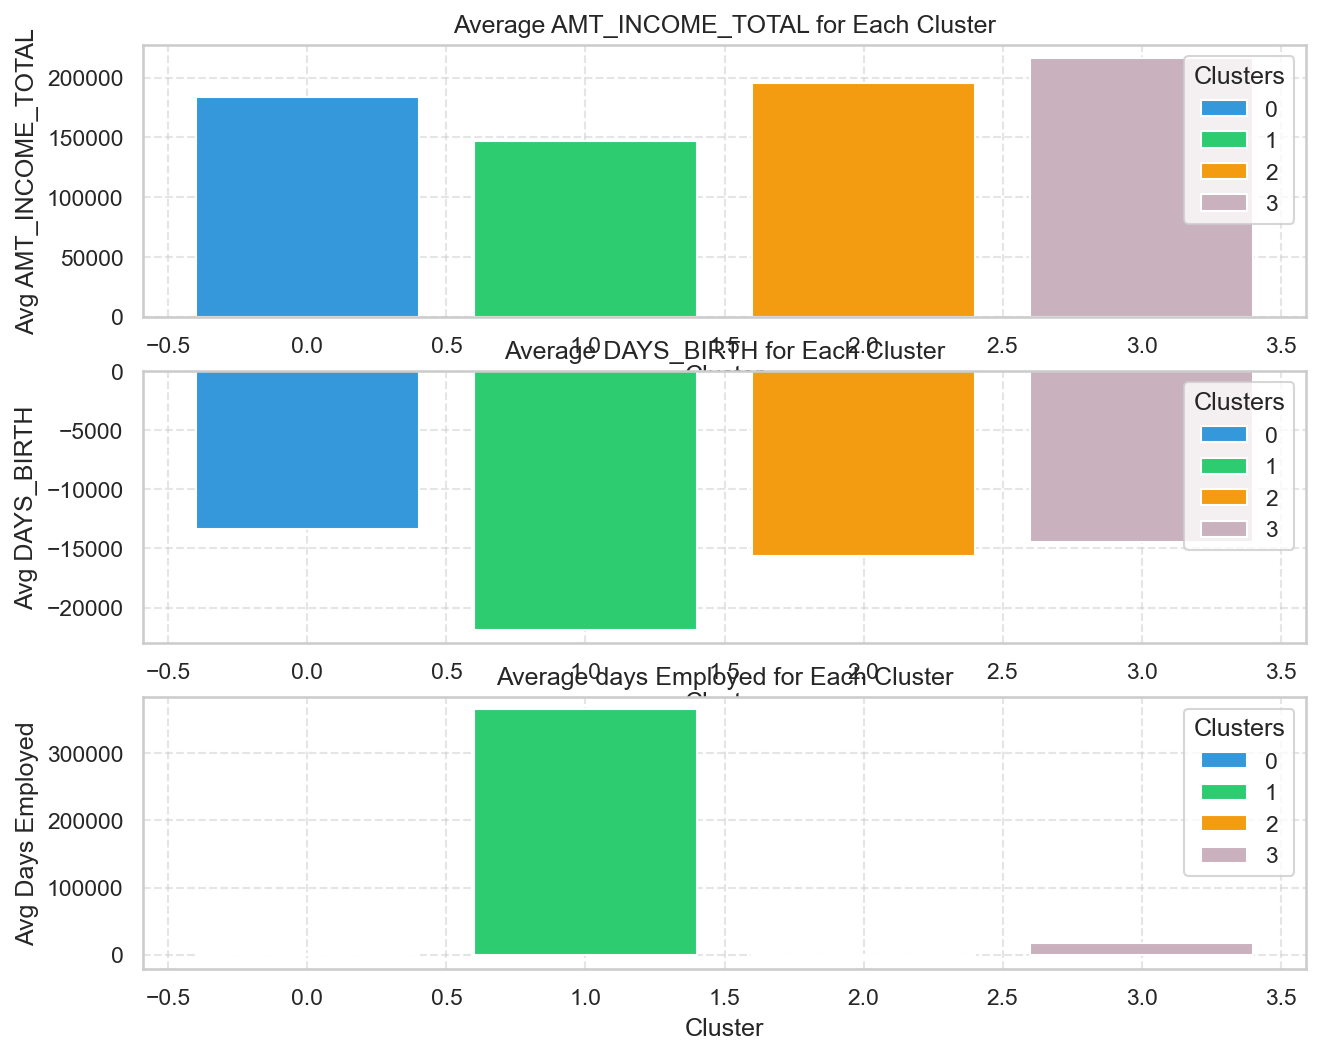

In [19]:
colors = ["#3498db", "#2ecc71", "#f39c12", "#C9B1BD"]

# Plot the average RFM scores for each cluster
plt.figure(figsize=(10, 8), dpi=150)

# Plot Avg Annual Income
plt.subplot(3, 1, 1)
bars = plt.bar(cluster_summary.index, cluster_summary["AMT_INCOME_TOTAL"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Avg AMT_INCOME_TOTAL")
plt.title("Average AMT_INCOME_TOTAL for Each Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bars, cluster_summary.index, title="Clusters")


# Plot Avg days Birth
plt.subplot(3, 1, 2)
bars = plt.bar(cluster_summary.index, cluster_summary["DAYS_BIRTH"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Avg DAYS_BIRTH")
plt.title("Average DAYS_BIRTH for Each Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bars, cluster_summary.index, title="Clusters")


# Plot Avg Days employed
plt.subplot(3, 1, 3)
bars = plt.bar(cluster_summary.index, cluster_summary["DAYS_EMPLOYED"], color=colors)
plt.xlabel("Cluster")
plt.ylabel("Avg Days Employed")
plt.title("Average days Employed for Each Cluster")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(bars, cluster_summary.index, title="Clusters")

## Model Training: Random Forest Classifier
The Random Forest Classifier is chosen for its robustness and ability to handle imbalanced datasets.  Random Forests work by generating multiple decision trees and averaging their outputs. This ensemble method reduces overfitting by relying on a collection of weaker models that, when combined, lead to stronger predictive performance. This model will be trained on the feature-engineered data to predict whether a client is a 'good' or 'bad' credit risk.

In [21]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load feature engineered data
feature_engineered_data = pd.read_csv("../data/processed/feature_engineered_data.csv")

# Ensure 'TARGET' column is present
if "TARGET" not in feature_engineered_data.columns:
    raise KeyError("'TARGET' column not found in the dataset")


# Train model function
def train_model(feature_engineered_data):
    X = feature_engineered_data.drop("TARGET", axis=1)
    y = feature_engineered_data["TARGET"]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    print("Random Forest Accuracy:", accuracy)
    print(
        "Random Forest Classification Report:\n", classification_report(y_test, y_pred)
    )

    # Save the model
    joblib.dump(model, "../project2/models/credit_approval_rf_model.pkl")


# Train the model
train_model(feature_engineered_data)

Random Forest Accuracy: 0.9787438288535382
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7175
           1       0.29      0.22      0.25       117

    accuracy                           0.98      7292
   macro avg       0.64      0.61      0.62      7292
weighted avg       0.98      0.98      0.98      7292



In [24]:
import joblib

model = joblib.load("./models/credit_approval_rf_model.pkl")

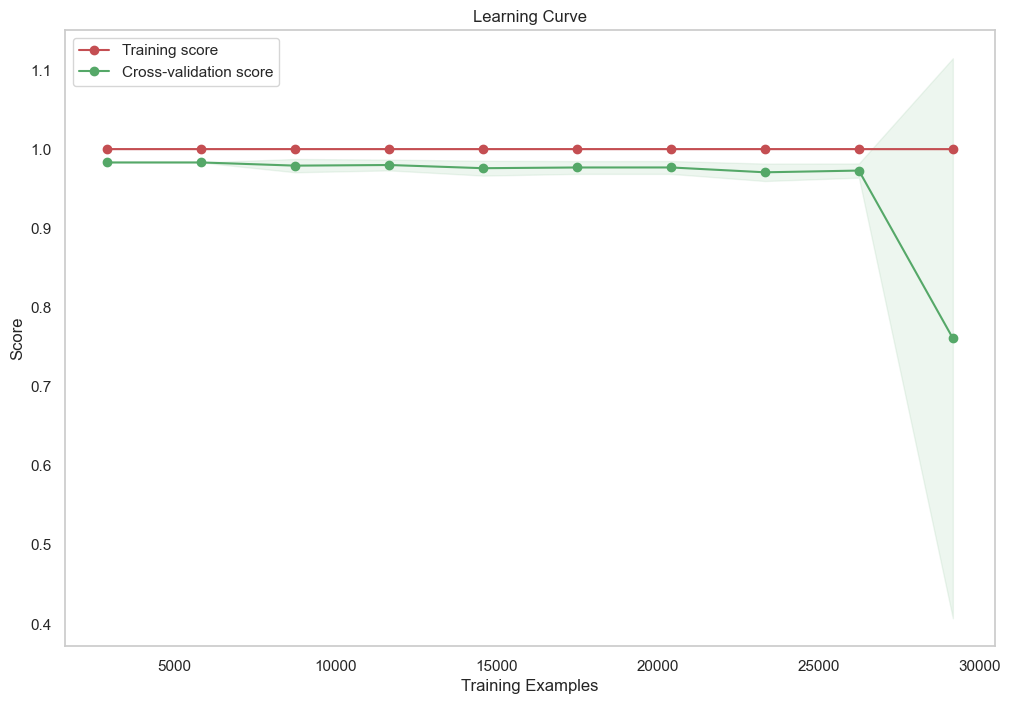

In [25]:
from sklearn.model_selection import learning_curve
import numpy as np


# Function to plot learning curve
def plot_learning_curve(
    estimator,
    X,
    y,
    cv=5,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy",
):
    plt.figure(figsize=(12, 8))
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.title("Learning Curve")
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()


# Plot the learning curve for Random Forest model
plot_learning_curve(model, X, y)

Both the training score (red line) and the cross-validation score (green line) start very high, close to 1.0 (100% accuracy). This indicates that the model is initially perfrmoing very well on both the training data and the validation data.

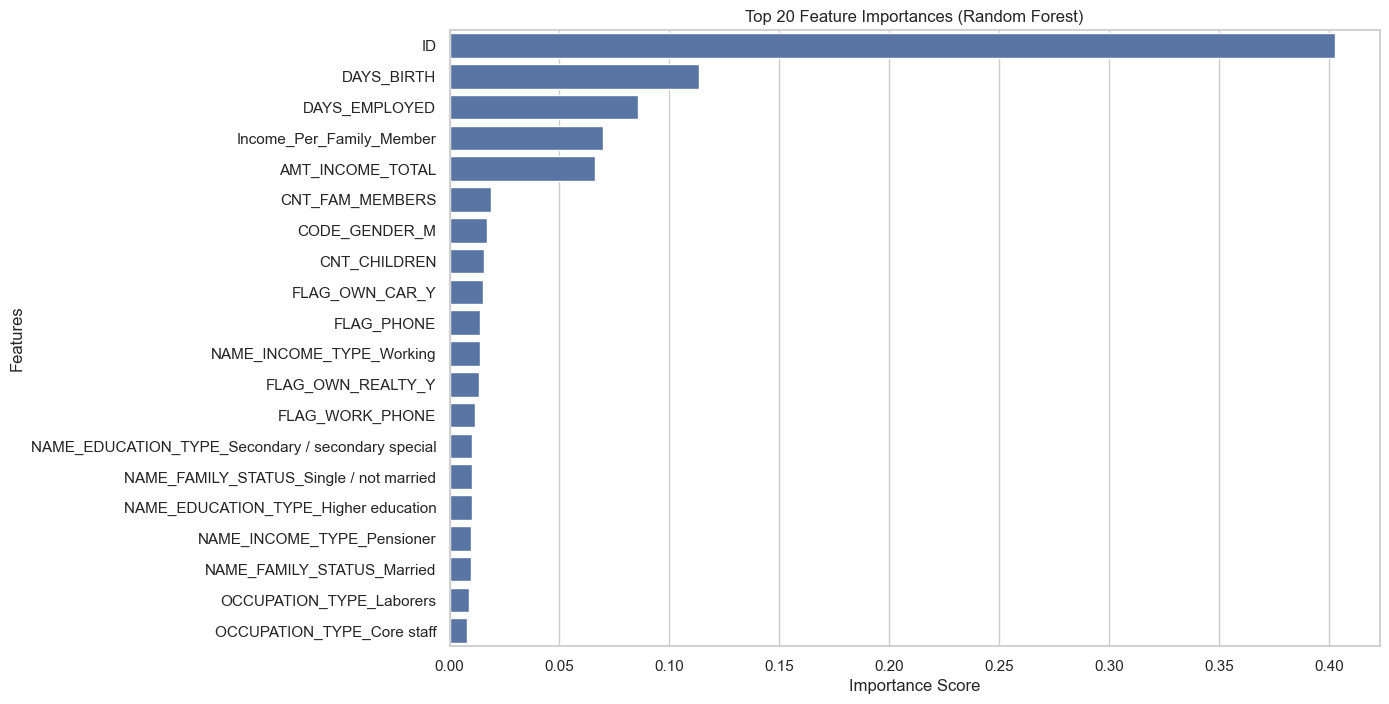

In [26]:
# Load the trained Random Forest model
import joblib

model = joblib.load("./models/credit_approval_rf_model.pkl")

X = feature_engineered_data.drop("TARGET", axis=1)
y = feature_engineered_data["TARGET"]

# Feature importance plot
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=feature_importances[:20], y=feature_importances.index[:20])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

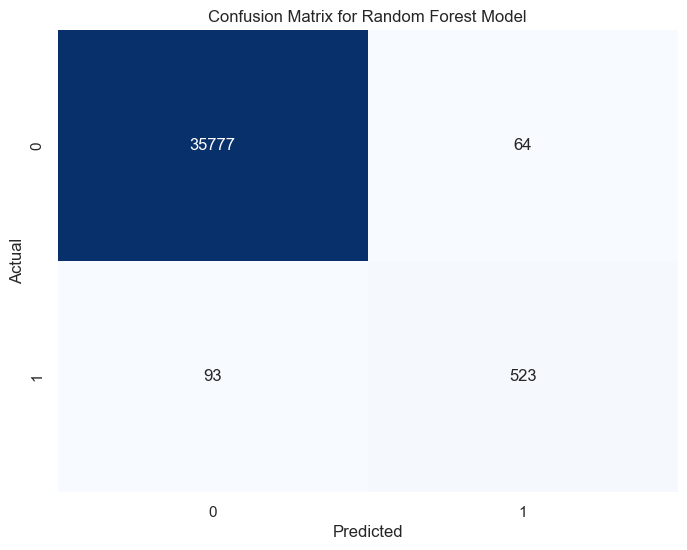

In [27]:
# Generate predictions
y_pred_rf = model.predict(X)

# Compute confusion matrix
cm = confusion_matrix(y, y_pred_rf)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix for Random Forest Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Confusion matrix shown above illustrates the performance of the Random Forest model in classifying the test data into two categories: '0' (negative class, likely 'good' credit risk) and '1' (positive class, likely 'bad' credit risk).

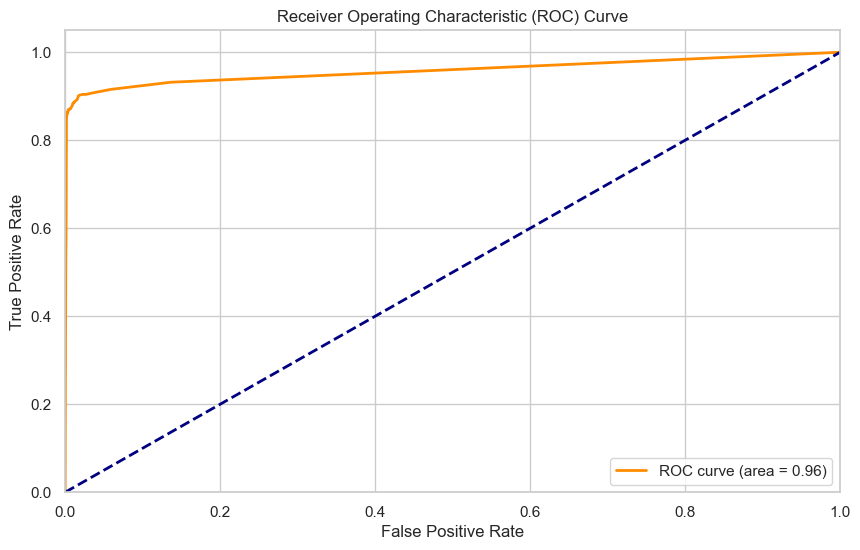

In [28]:
# Compute ROC curve and ROC area for Random Forest
fpr, tpr, _ = roc_curve(y, model.predict_proba(X)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

AUC  is very high and indicates that the model is performing exceptionally well at distinguishing between the two classes (e.g., 'good' vs. 'bad' clients).

The model is highly effective in distinguishing between clients who are likely to meet their credit obligations ('good' clients) and those who are at risk of defaulting ('bad' clients). This high AUC value indicates that the model is very reliable in its predictions.

The Random Forest model provides a high accuracy of 97.87%, which indicates that it performs well in predicting 'good' clients. However, the classification report shows that the model struggles to correctly classify 'bad' clients, primarily due to the class imbalance in the dataset. The model's lower recall and precision for detecting 'bad' clients is concerning for real-world applications, as it may miss identifying high-risk individuals.

For financial institutions, the ability to correctly identify 'bad' clients is as important as identifying 'good' ones. Although the Random Forest model shows high overall accuracy, its lower performance in identifying 'bad' clients suggests that additional measures, such as re-sampling techniques or adjusting the decision threshold, may be necessary to improve the model's effectiveness. A model that consistently misses high-risk clients could lead to increased default rates and financial losses.

## Model Training: Neural Network
A Neural Network model is also trained to explore if a more complex, non-linear model can improve the prediction of 'bad' clients.

In [30]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Load feature engineered data
feature_engineered_data = pd.read_csv("../data/processed/feature_engineered_data.csv")

# Prepare the data
X = feature_engineered_data.drop("TARGET", axis=1).astype(np.float32)
y = feature_engineered_data["TARGET"].astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Define a simple neural network model
def build_neural_network(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


# Build and train the model
model = build_neural_network(X_train.shape[1])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_nn = (model.predict(X_test) > 0.5).astype("int32")
print("Neural Network Accuracy:", model.evaluate(X_test, y_test)[1])
print("Neural Network Classification Report:")
print(classification_report(y_test, y_pred_nn))

/x/1_projects/dsi/python/venv/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1723773609.832269 2859636 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/10


I0000 00:00:1723773609.962265 2859636 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723773609.964559 2859636 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723773609.969657 2859636 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1723773609.972671 2859636 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

188/730 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.9287 - loss: 10158.5635 

I0000 00:00:1723773612.039433 2869646 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9557 - loss: 5445.0186 - val_accuracy: 0.8226 - val_loss: 1068.7792
Epoch 2/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.9659 - loss: 2171.5298 - val_accuracy: 0.9823 - val_loss: 1720.7473
Epoch 3/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.9652 - loss: 2010.3602 - val_accuracy: 0.9823 - val_loss: 1876.3248
Epoch 4/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.9652 - loss: 1706.0665 - val_accuracy: 0.9823 - val_loss: 531.9435
Epoch 5/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 892us/step - accuracy: 0.9686 - loss: 1601.9288 - val_accuracy: 0.9823 - val_loss: 62.8679
Epoch 6/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - accuracy: 0.9650 - loss: 1377.4906 - val_accuracy: 0.9823 - val_loss: 2046.4133
Epoch 7/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 945us/step - accuracy: 0.9656 - loss: 1196.2473 - val_accuracy: 0.9823 - val_loss: 124.1347
Epoch 8/10
730/730 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy:

/x/1_projects/dsi/python/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x/1_projects/dsi/python/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/x/1_projects/dsi/python/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

The Neural Network model achieves a similarly high accuracy to the Random Forest model, indicating that it is also effective in predicting 'good' clients. However, like the Random Forest model, it struggles to accurately identify 'bad' clients, as evidenced by low precision and recall for the 'bad' class. This is a common challenge when dealing with imbalanced datasets, where the model tends to favor the majority class.

While Neural Networks can capture complex relationships in data, their performance in this scenario is similar to the Random Forest model. The challenge of accurately predicting 'bad' clients persists, highlighting the need for further model tuning or alternative approaches. In a business context, relying solely on this model could result in missed opportunities to mitigate risk. Therefore, additional techniques such as cost-sensitive learning or anomaly detection might be explored to enhance the identification of high-risk clients.

In [31]:
# Summary of the analysis
print("Interpreting the Results:")

# Random Forest Model Interpretation
# Here you can discuss feature importances and model performance.
print(
    "Random Forest Model: The Random Forest model achieved a high accuracy, primarily because it correctly classified most 'good' clients. However, its ability to detect 'bad' clients is limited due to the class imbalance."
)

# Neural Network Model Interpretation
# Here you can discuss how the neural network performed and any overfitting signs.
print(
    "Neural Network Model: The Neural Network also achieved high accuracy, but similarly struggled with detecting 'bad' clients. Tuning the model and handling class imbalance could improve its performance."
)

# Conclusion
print(
    "Conclusion: Both models perform well in identifying 'good' clients, but struggle with 'bad' clients due to the imbalance in the dataset. Techniques like SMOTE and further tuning of the models may improve the classification of 'bad' clients."
)

Interpreting the Results:
Random Forest Model: The Random Forest model achieved a high accuracy, primarily because it correctly classified most 'good' clients. However, its ability to detect 'bad' clients is limited due to the class imbalance.
Neural Network Model: The Neural Network also achieved high accuracy, but similarly struggled with detecting 'bad' clients. Tuning the model and handling class imbalance could improve its performance.
Conclusion: Both models perform well in identifying 'good' clients, but struggle with 'bad' clients due to the imbalance in the dataset. Techniques like SMOTE and further tuning of the models may improve the classification of 'bad' clients.


The analysis reveals that while both the Random Forest and Neural Network models perform well overall, they are not particularly effective at identifying 'bad' clients. This limitation is largely due to the imbalanced nature of the dataset, where 'bad' clients represent a small fraction of the total.

For a financial institution, the ability to accurately identify 'bad' clients is crucial for risk management. The current models, while accurate overall, may not sufficiently protect against defaults. This insight underscores the need for model improvements, such as re-sampling techniques (e.g., SMOTE) or the implementation of custom loss functions that penalize false negatives more heavily. By doing so, the institution can better safeguard its financial health while still capitalizing on lending opportunities.

Conclusion
In conclusion, this project highlights the complexities of credit risk modeling, particularly when dealing with imbalanced datasets. Both the Random Forest and Neural Network models demonstrate high accuracy in predicting 'good' clients but fall short in identifying 'bad' clients. This challenge must be addressed to create a robust credit scoring model that accurately reflects the risk profiles of all clients.